# Прогнозирование количества заказов такси
## Постановка задачи
Заказчик проекта - компания «Чётенькое такси». Заказчик собрал исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Для этого нужно построить и обучить модель на имеющемся датасете.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Импорт библиотек

In [1]:
!pip install statsmodels 

import math # standard
from math import ceil # standard
from pathlib import Path # standard
import random # standard
import warnings # standard library
warnings.filterwarnings('ignore')

from catboost import CatBoostRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:,.4f}'.format)
from scipy import stats
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

Defaulting to user installation because normal site-packages is not writeable
--- Logging error ---
Traceback (most recent call last):
  File "/home/klarazetkin/.local/lib/python3.8/site-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/home/klarazetkin/.local/lib/python3.8/site-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/home/klarazetkin/.local/lib/python3.8/site-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/home/klarazetkin/.local/lib/python3.8/site-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/home/klarazetkin/.local/lib/python3.8/site-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/home/klarazetkin/.local/lib/python3.8/site-packages/pip/_vendor/r

## Импорт и первичное исследование данных
### Импорт данных

In [2]:
my_path = Path('/home/klarazetkin/Documents/yandex/module_5/project_1')
file_name = str(my_path) + '/' + 'taxi.csv'
if my_path.is_dir():
    df = pd.read_csv(file_name, index_col=[0], parse_dates=[0])
else:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    
# сохраним резервную копию исходного датасета
df_original = df 

### Первичное исследование данных
Исходные данные - датасет на 26_496 строк и одну колонку. Колонку с датами импортировали как индекс. Вторая колонка - количество заказов в формате int64. Пропусков нет. 

Датасет включает в себя данные за полгода - с 1 марта по 31 августа 2018, то есть сезонные колебания (зима, весна, лето, осень) отследить на датасете не получится.

Данные имеют шаг 10 минут.

In [3]:
def overall_info(df):
    print('Shape:')
    print(df.shape)
    print()
    print('Head:')
    display(df.head())
    print()
    print('Describe df:')
    display(df.describe())
    print(); print()
    print(df.info())
    print(); print()
    print('Nan values:')
    display(df.isna().mean())
    print('Distributions of numerical values:')
    df.hist(figsize=(27, 9))

Shape:
(26496, 1)

Head:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



Describe df:


,num_orders
count,"26,496.0000"
mean,14.0705
std,9.2113
min,0.0000
25%,8.0000
50%,13.0000
75%,19.0000
max,119.0000




<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Nan values:


num_orders   0.0000
dtype: float64

Distributions of numerical values:


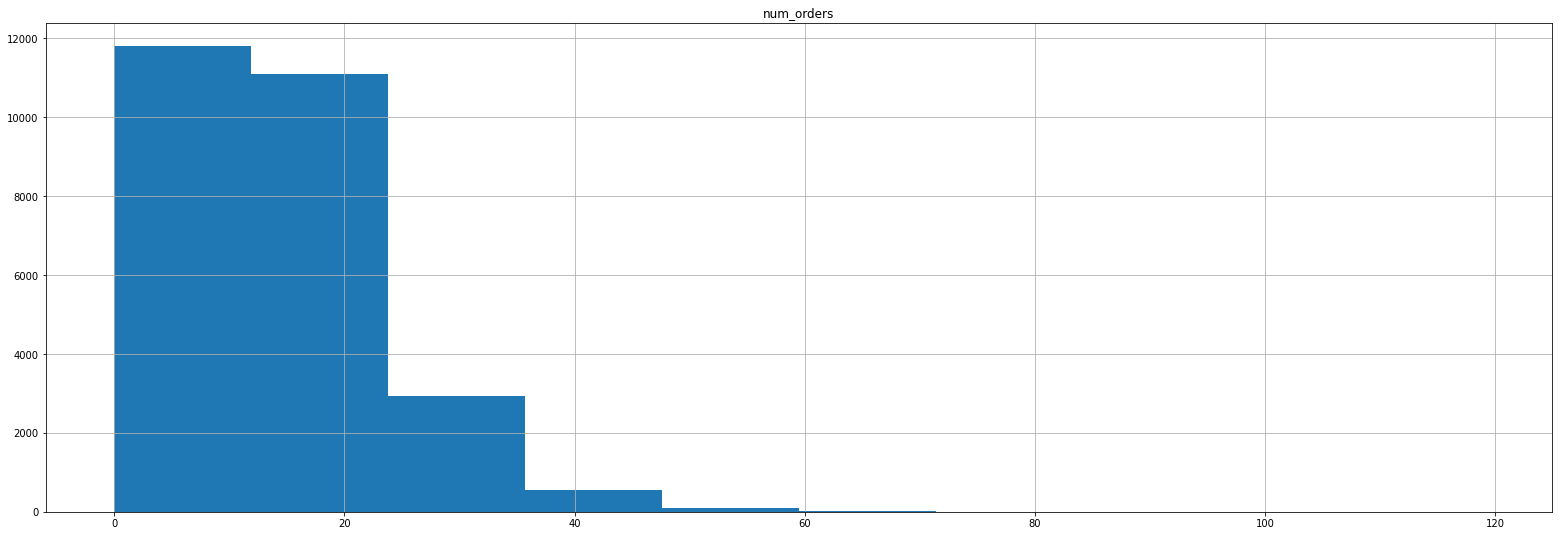

In [4]:
overall_info(df)

In [5]:
df.sort_index(inplace=True)

In [6]:
print(df.index.min())
print(df.index.max())

2018-03-01 00:00:00
2018-08-31 23:50:00


In [7]:
print(df.index.is_monotonic)

True


### Распределение данных в исходном датасете
Проверим распределение данных в исходном датасете.

In [8]:
def show_time_series(df=df, column_name='num_orders'):
    plt.figure(figsize=(20, 5))
    x = df.index
    y = df.num_orders
    plt.plot(x, y)
    plt.show()

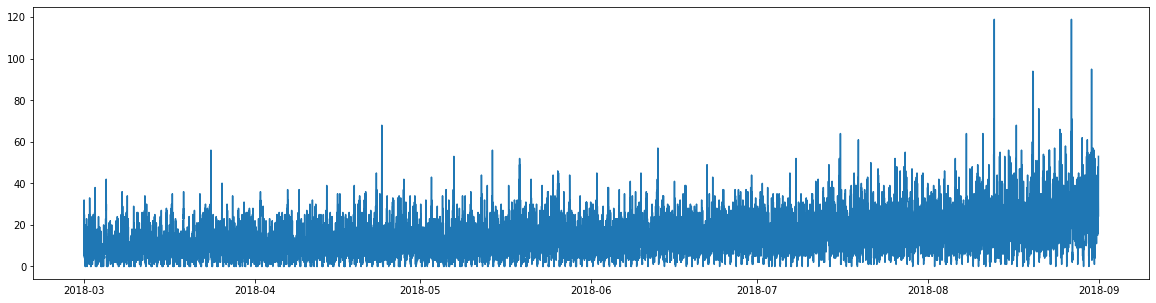

In [9]:
show_time_series(df_original)

## Предобработка данных
Лишних столбцов нет, дубликатов не может быть, т.к. индекс - уникальная дата+время. Единственный столбец поименован нормально, тип данных соответствует физическому смыслу столбца (менять типы данных не надо), пропусков нет. Датасет в целом пригоден для задачи.
### Ресемплинг данных
В задании указано, что предсказывать нужно нагрузку на следующий час. Ресемплируем данные, изменив интервал, проконтролируем, что данные изменены корректно.

In [10]:
df['num_orders'].sum()

372811

In [11]:
df = df.resample('1H').sum()
df['num_orders'].sum()

372811

In [12]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


### Распределение данных
Посмотрим, как выглядит временной ряд на графике после ресемплинга.

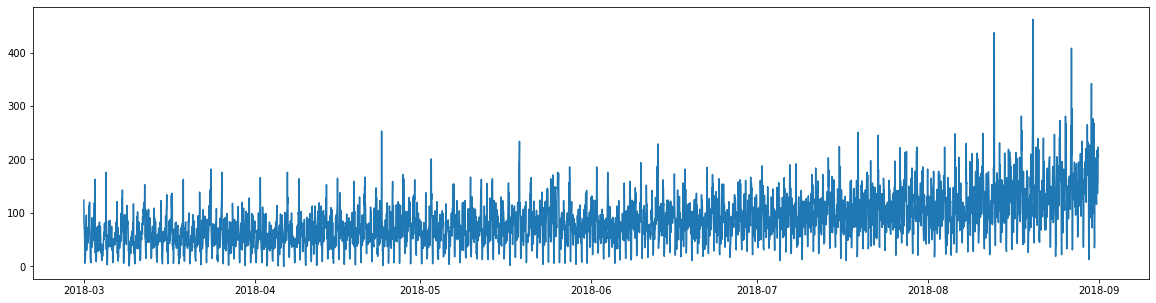

In [13]:
show_time_series(df)

Данные выстраиваются в одну линию, возможно, они нормально будут описаны линейной регрессией.

Разложим данные на тренд, сезонность и остатки. Видим, что тренд идет на рост, сезонность нужно смотреть на более мелком графике, но зависимость прослеживается явно. На недельном графике явно видна суточная динамика. 

Кроме того, довольно большой разброс остатков, скорей всего, это будет путать модель.

Временной ряд не стационарный, со временем меняется его среднее значение.

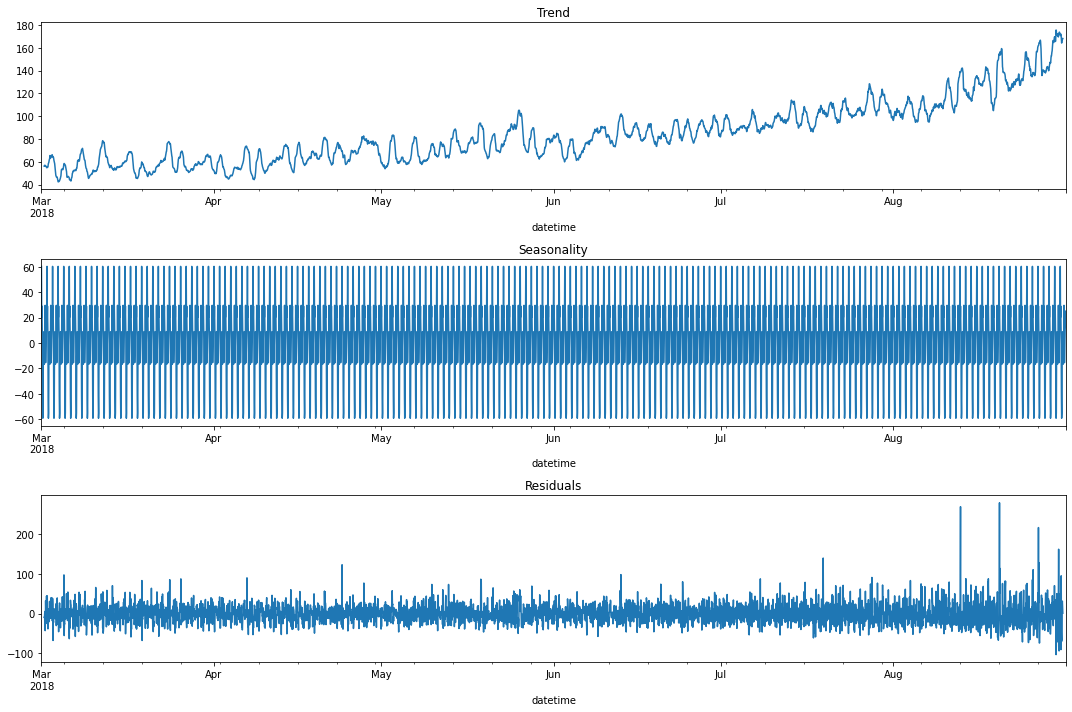

In [14]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Text(0.5, 1.0, 'Seasonality')

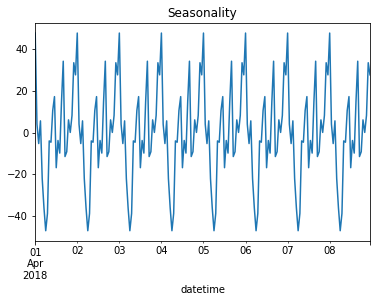

In [15]:
weekly_decomposed = seasonal_decompose(df['2018-04-01':'2018-04-08']['num_orders'])
weekly_decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

### Обработка выбросов
Проверим колонку `num_orders` на выбросы. Существенных выбросов нет, но подровняем правый хвост графика по значению `num_orders = 300`.

In [16]:
sns.set(rc={'figure.figsize':(10,5)})

def print_hist_for_one_column(column_name='num_orders', title='График распределения', bins=10):
    ax = df[column_name].hist(bins=bins)
    ax.set_title(title)
    ax.set_xlabel(column_name)
    ax.set_ylabel('Объекты датасета')

In [17]:
def print_boxplot(column=df['num_orders'], title='Ящик с усами'):
    sns.boxplot(x=column)
    plt.title(title)
    plt.show()

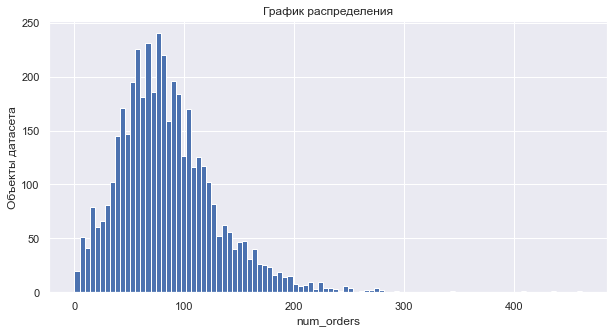

In [18]:
# первоначальный график распределения объектов в колонке 'registration_year'
print_hist_for_one_column(column_name='num_orders', bins=100)

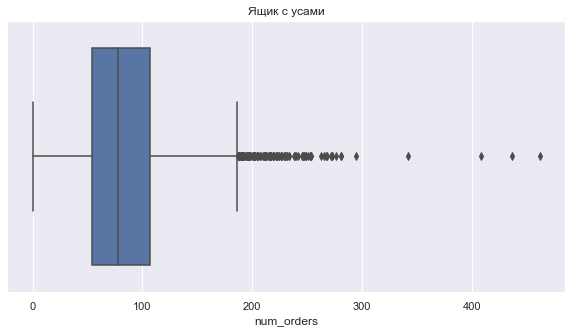

In [19]:
print_boxplot(df['num_orders'])

In [20]:
print(df.query('num_orders > 300'))
print(df.query('num_orders > 300').index.day_of_week)

                     num_orders
datetime                       
2018-08-13 02:00:00         437
2018-08-20 02:00:00         462
2018-08-27 02:00:00         408
2018-08-30 17:00:00         342
Int64Index([0, 0, 0, 3], dtype='int64', name='datetime')


<AxesSubplot:xlabel='datetime'>

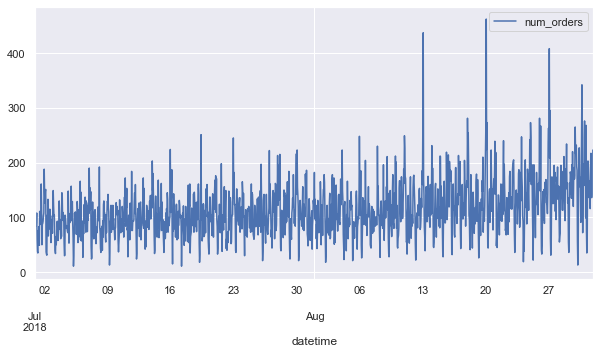

In [21]:
df['2018-07-01':'2018-08-31'].plot()

In [22]:
last_month = df['2018-06-20':'2018-08-12']
dayofweek = last_month.index.day_of_week
hour = last_month.index.hour

In [23]:
# вот так было по понедельникам в 02:00 до аномалии:
display(last_month.iloc[((dayofweek == 0) & (hour == 2))])
before_anomaly_median_monday = last_month.iloc[((dayofweek == 0) & (hour == 2))].median()
print('Median before anomaly Monday:', before_anomaly_median_monday)
before_anomaly_median_thursday = last_month.iloc[((dayofweek == 3) & (hour == 17))].median()
print('Median before anomaly Thursday:', before_anomaly_median_thursday)

,num_orders
datetime,
2018-06-25 02:00:00,82
2018-07-02 02:00:00,126
2018-07-09 02:00:00,142
2018-07-16 02:00:00,126
2018-07-23 02:00:00,182
2018-07-30 02:00:00,223
2018-08-06 02:00:00,104


Median before anomaly Monday: num_orders   126.0000
dtype: float64
Median before anomaly Thursday: num_orders   118.5000
dtype: float64


In [24]:
df.loc[df['num_orders'] == 342, 'num_orders'] = before_anomaly_median_thursday

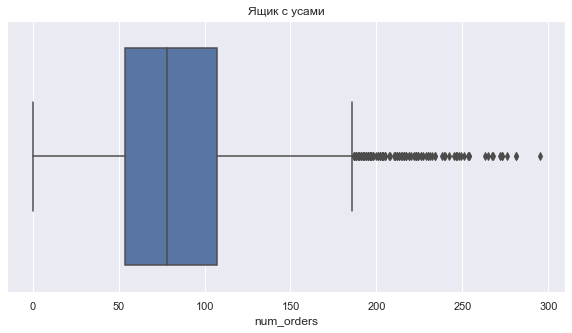

In [25]:
df.loc[df['num_orders'] > 300, 'num_orders'] = before_anomaly_median_monday
print_boxplot(df['num_orders'])

### Создание дополнительных обучающих признаков
Создадим дополнительные обучающие признаки. Для первых девяти часов часть новых признаков будет пустой, удалим эти строки.

In [28]:
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    # data['month'] = data.index.month # remove?
    data['day_of_month'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour.astype(np.uint8) # ДОБАВИЛ РЕВЬЮЕР
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(df, 1, 24)

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА 2</b></u></p>
Со скользящим средним - можно поэкспериментировоать. Мысль интересная. Тут ещё вот что в голове можно держать: изнеса нужен не просто прогоз (чаще всего) а понимание того, за счёт каких факторов может быть ошибка прогноза. И вот в этой концепции важно иметь в модели факторы, которые мы можем понять и объяснить.<br>
    
По этой же причине и с лагами. В пределе, кончено же, можно сделать отдельный столбец п каждому значени (это и будет заявленный концепт - чем больше лагов, тем лучше))). Но какова ценность той модели на практике будет? никакая)))) Поэтому с количеством лагов - нужен разумный балланс. Вот и предложил начинать их и минимума вставлять.

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Тогда по идее можно и лаги добавить за час, сутки и за неделю, чтоб помнить, что было неделю назад, раз есть недельная и суточная сезонность? Или это вредно и бесполезно?
</div>

<font color='blue'><b>

In [31]:
df = df.dropna()
df.head(20)

,num_orders,day_of_month,day_of_week,hour,lag_1,rolling_mean
datetime,,,,,,
2018-03-02 00:00:00,90.0000,2,4,0,58.0000,56.8333
2018-03-02 01:00:00,120.0000,2,4,1,90.0000,55.4167
2018-03-02 02:00:00,75.0000,2,4,2,120.0000,56.8750
2018-03-02 03:00:00,64.0000,2,4,3,75.0000,57.0417
2018-03-02 04:00:00,20.0000,2,4,4,64.0000,56.9583
2018-03-02 05:00:00,11.0000,2,4,5,20.0000,56.0000
2018-03-02 06:00:00,11.0000,2,4,6,11.0000,56.2083
2018-03-02 07:00:00,7.0000,2,4,7,11.0000,56.1667
2018-03-02 08:00:00,46.0000,2,4,8,7.0000,55.8333


Масштабировать данные не нужно. Кодировать категориальные данные не нужно ввиду их отсутствия. Считаем, что данные пригодны к обучению модели.

## Подготовка обучающего и тестового датасетов
Подготовим обучающий и тестовый датасеты. Разделим исходный датасет на два в соотношении 4:1.

In [32]:
features = df.drop(['num_orders'], axis=1)
target = df['num_orders']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=666, shuffle=False)

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
shuffle=False - то что надо здесь!
</div>

Проверим, что данные разделены корректно.

In [33]:
print(features_train.shape)
print(features_test.shape)

(3433, 5)
(859, 5)


In [34]:
print(features_train.index.min())
print(features_train.index.max())
print(features_test.index.min())
print(features_test.index.max())

2018-03-02 00:00:00
2018-07-23 00:00:00
2018-07-23 01:00:00
2018-08-31 23:00:00


## Обучение моделей
Создадим и обучим на датасетах модели, проверим качество предсказаний. Сравнивать будем со стандартным отклонением и средним.

In [35]:
df['num_orders'].describe()

count   4,292.0000
mean       82.9357
std        42.6831
min         0.0000
25%        54.0000
50%        78.0000
75%       106.0000
max       281.0000
Name: num_orders, dtype: float64

In [36]:
# метод для визуализации предсказаний
def graph_for_fact_and_preds(preds, target, title='Target and predictions'):
    preds = list(np.array(preds.tolist()).flat)
    target = list(np.array(target.tolist()).flat)

    n = len(preds)
    r = np.arange(n)
    width = 0.4

    plt.figure(figsize=(30,20)) 
    
    plt.bar(r, preds, color = 'b',
            width = width, edgecolor = 'black',
            label='preds')
    plt.bar(r + width, target, color = 'g',
            width = width, edgecolor = 'black',
            label='target')

    plt.xlabel("Day number")
    plt.ylabel("Orders")
    plt.title(title)

    plt.xticks(r + width/2, np.arange(n))
    plt.legend()

    plt.show()

In [37]:
# метод для визуализации предсказаний
def graph_for_fact_and_preds_lines(dates, preds, target, title='Target and predictions'):
    x_ticks = list(dates)
    
    preds = list(np.array(preds.tolist()).flat)
    target = list(np.array(target.tolist()).flat)

    plt.plot(x_ticks, preds, label='preds')
    plt.plot(x_ticks, target, label='target')

    plt.xlabel('dates')
    plt.ylabel('orders')
    plt.title(title)
    plt.legend()
    
    plt.show()

### Dummy models
#### Dummy Regressor
Чтоб было с чем сравнивать, обучим DummyRegressor и оценим качество его предсказаний.

In [38]:
dummy_model = DummyRegressor(strategy="median")
dummy_model.fit(features_train, target_train)

dummy_predicted_train = dummy_model.predict(features_train)
dummy_rmse_train = np.sqrt(mean_squared_error(target_train, dummy_predicted_train))

print("RMSE обучающей выборки:", dummy_rmse_train)

RMSE обучающей выборки: 35.52962438791774


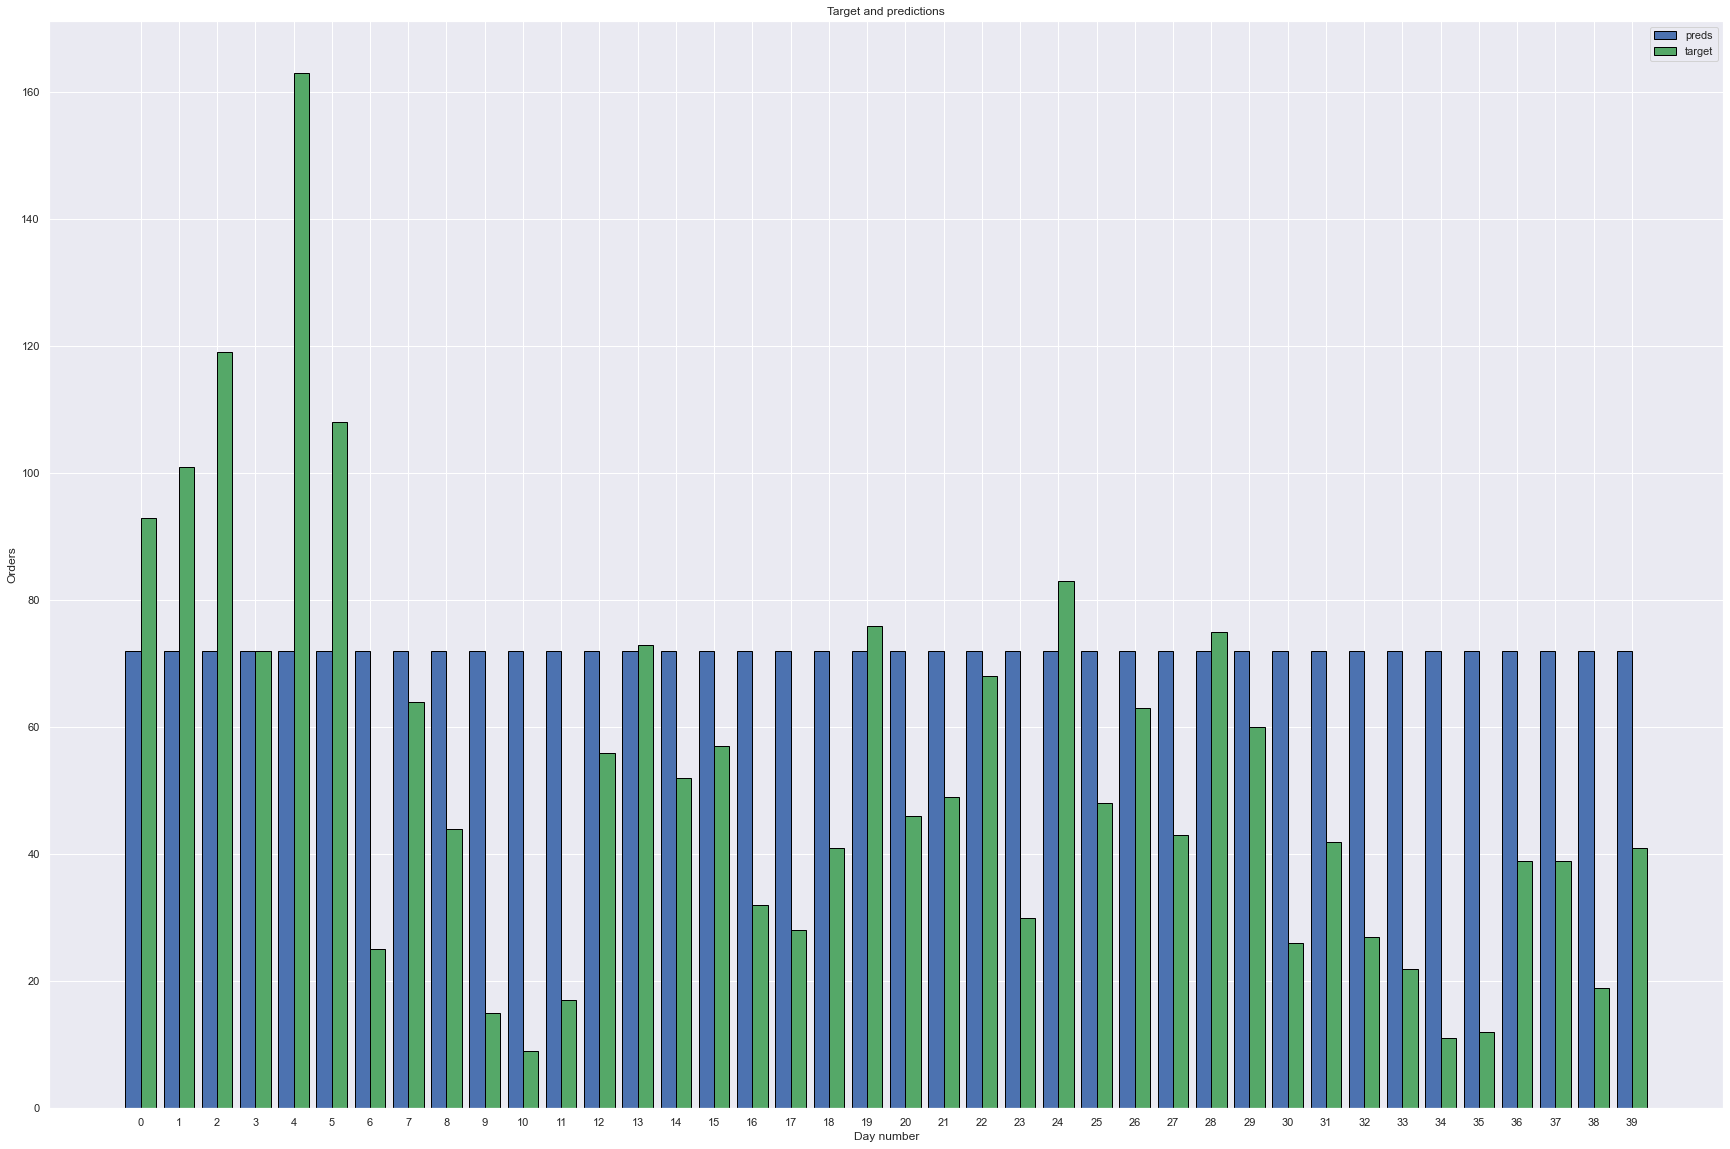

In [39]:
# визуализируем предсказания и таргет
start, end = 20, 60
graph_for_fact_and_preds(dummy_predicted_train[start:end], target_train[start:end])

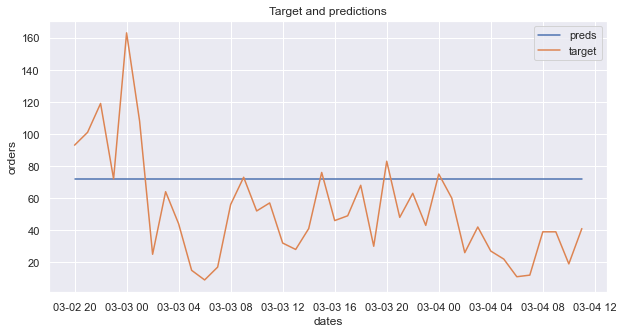

In [40]:
graph_for_fact_and_preds_lines(target_train.index[start:end], dummy_predicted_train[start:end], target_train[start:end])

#### Dummy model-2
Оценим предсказания модели, которая всегда предсказывает предыдущее значение. Эта модель намного адекватней для временных рядов.

In [41]:
previous_predicted_train = target_train.shift(fill_value=target_train.iloc[1])
previous_rmse_train = np.sqrt(mean_squared_error(target_train, previous_predicted_train))
print("RMSE обучающей выборки:", previous_rmse_train)

RMSE обучающей выборки: 34.3367051607071


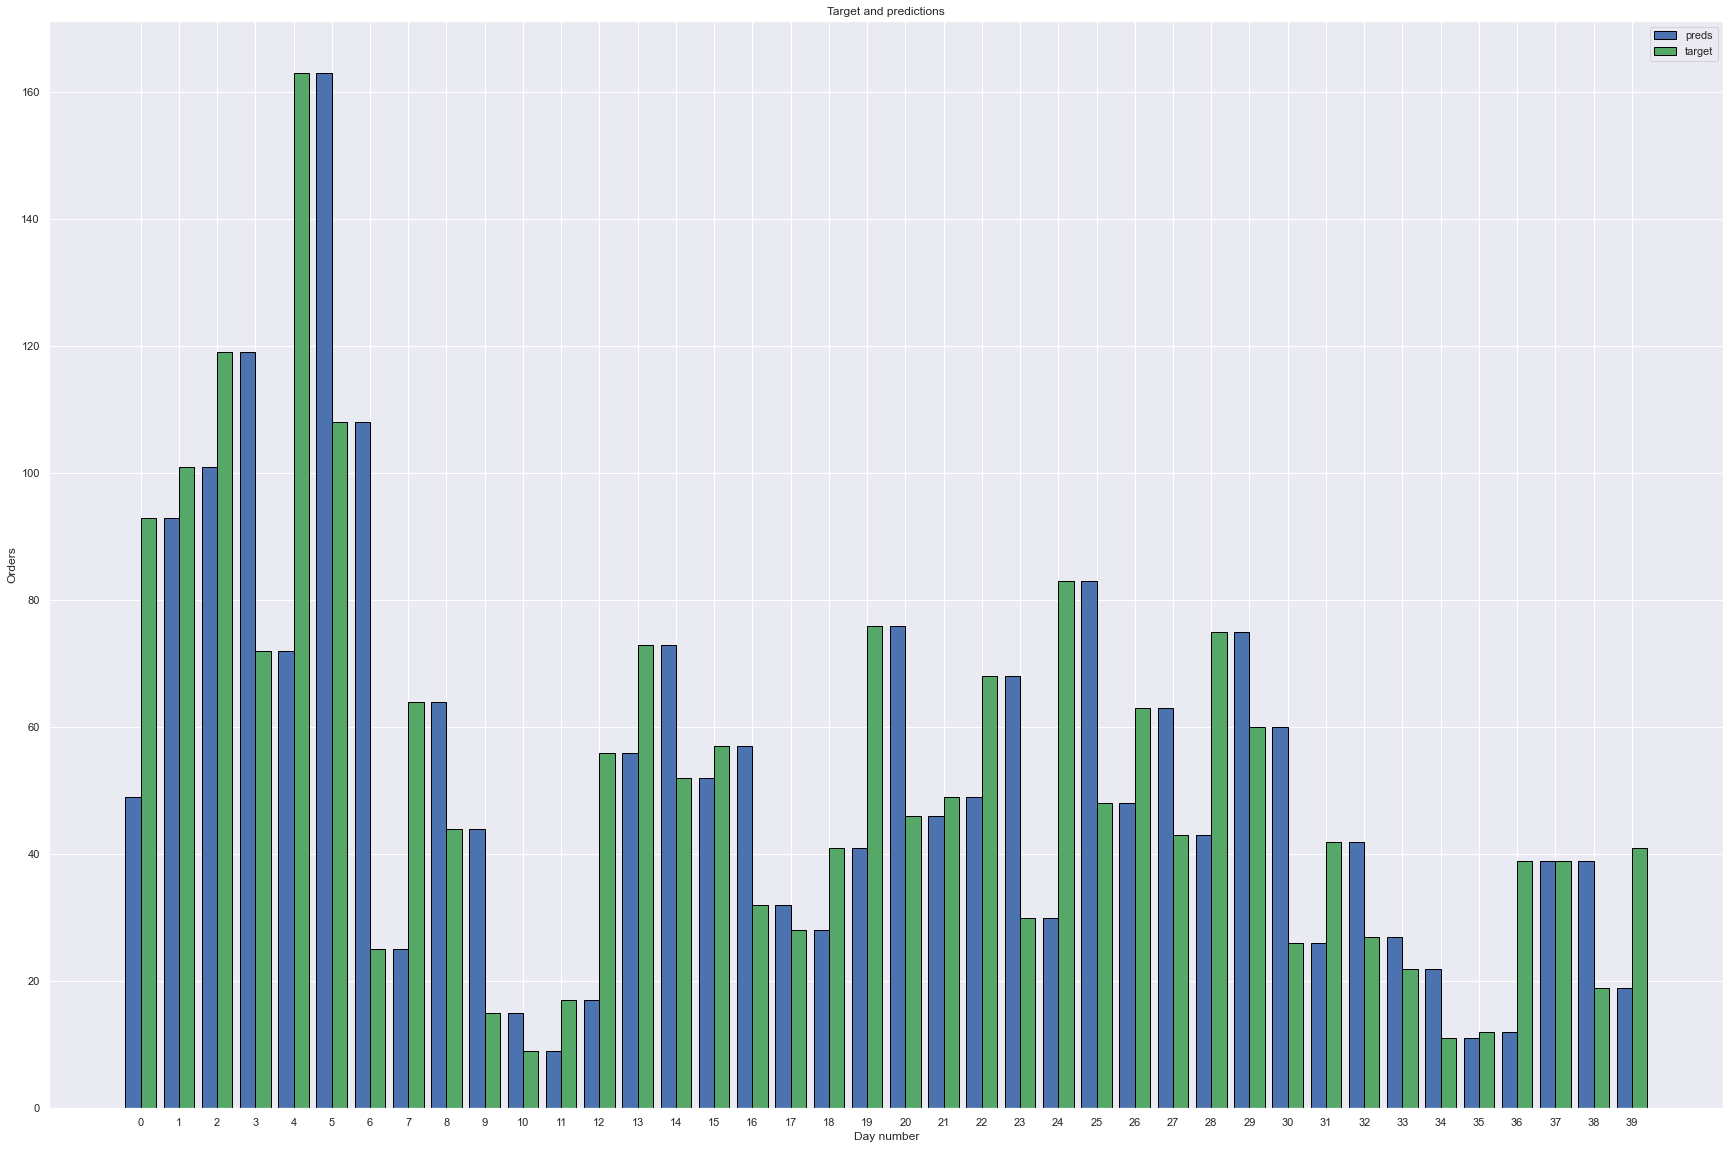

In [42]:
# визуализируем предсказания и таргет
graph_for_fact_and_preds(previous_predicted_train[start:end], target_train[start:end])

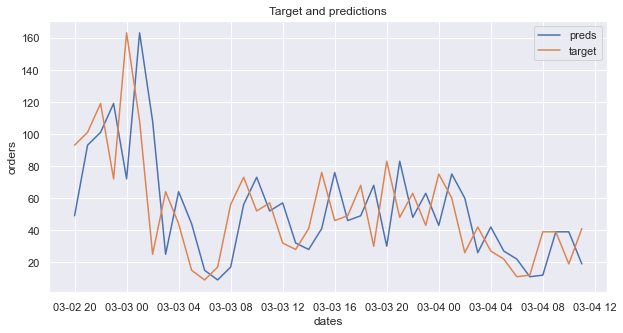

In [43]:
graph_for_fact_and_preds_lines(target_train.index[start:end], previous_predicted_train[start:end], target_train[start:end])

### Линейная регрессия
Обучим модель линейной регрессии.

In [44]:
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)

lr_predicted_train = lr_model.predict(features_train)
lr_rmse_train = np.sqrt(mean_squared_error(target_train, lr_predicted_train))
print("RMSE обучающей выборки:", lr_rmse_train)

RMSE обучающей выборки: 29.290170248169026


Попробуем подобрать параметры для линейной регрессии.

In [45]:
%%time
estimator = LinearRegression()

params = {'fit_intercept': [True, False],
          'positive': [True, False]
         }

tscv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(estimator, 
                   param_grid=params, 
                   scoring='neg_root_mean_squared_error', 
                   refit=True,
                   n_jobs=-1, 
                   cv=tscv, 
                   return_train_score=True,
                   verbose=1)

grid.fit(features_train, target_train) 

Fitting 8 folds for each of 4 candidates, totalling 32 fits
CPU times: user 128 ms, sys: 52.1 ms, total: 180 ms
Wall time: 1.71 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'positive': [True, False]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=1)

In [50]:
print(grid.best_params_)
print(np.sqrt(abs(grid.best_score_))) 
print(np.sqrt(mean_squared_error(target_train, grid.predict(features_train))))

{'fit_intercept': False, 'positive': True}
5.4496100003614405
29.29774162353356


In [47]:
for x in grid.cv_results_:
    print(x)
    print(grid.cv_results_[x])
    print()

mean_fit_time
[0.01032457 0.00965375 0.00567237 0.00584695]

std_fit_time
[0.00619822 0.00478494 0.00060972 0.00067238]

mean_score_time
[0.0034456  0.00497586 0.00354648 0.00287041]

std_score_time
[0.00067244 0.00330251 0.00155282 0.00048891]

param_fit_intercept
[True True False False]

param_positive
[True False True False]

params
[{'fit_intercept': True, 'positive': True}, {'fit_intercept': True, 'positive': False}, {'fit_intercept': False, 'positive': True}, {'fit_intercept': False, 'positive': False}]

split0_test_score
[-25.83178472 -25.83178472 -25.89498608 -25.89498608]

split1_test_score
[-24.34043911 -24.34043911 -24.41054523 -24.41054523]

split2_test_score
[-30.55911472 -30.55911472 -30.44916738 -30.44916738]

split3_test_score
[-29.57351886 -29.57351886 -29.50193436 -29.50193436]

split4_test_score
[-29.9579198  -29.9579198  -29.88459129 -29.88459129]

split5_test_score
[-30.44039567 -30.44039567 -30.3702471  -30.3702471 ]

split6_test_score
[-31.4457018  -31.4457018  -

In [51]:
lr_model_2 = LinearRegression(fit_intercept=False, positive=True)
lr_model_2.fit(features_train, target_train)

lr2_predicted_train = lr_model_2.predict(features_train)
lr2_rmse_train = np.sqrt(mean_squared_error(target_train, lr2_predicted_train))

print("RMSE обучающей выборки:", lr2_rmse_train)

RMSE обучающей выборки: 29.29774162353356


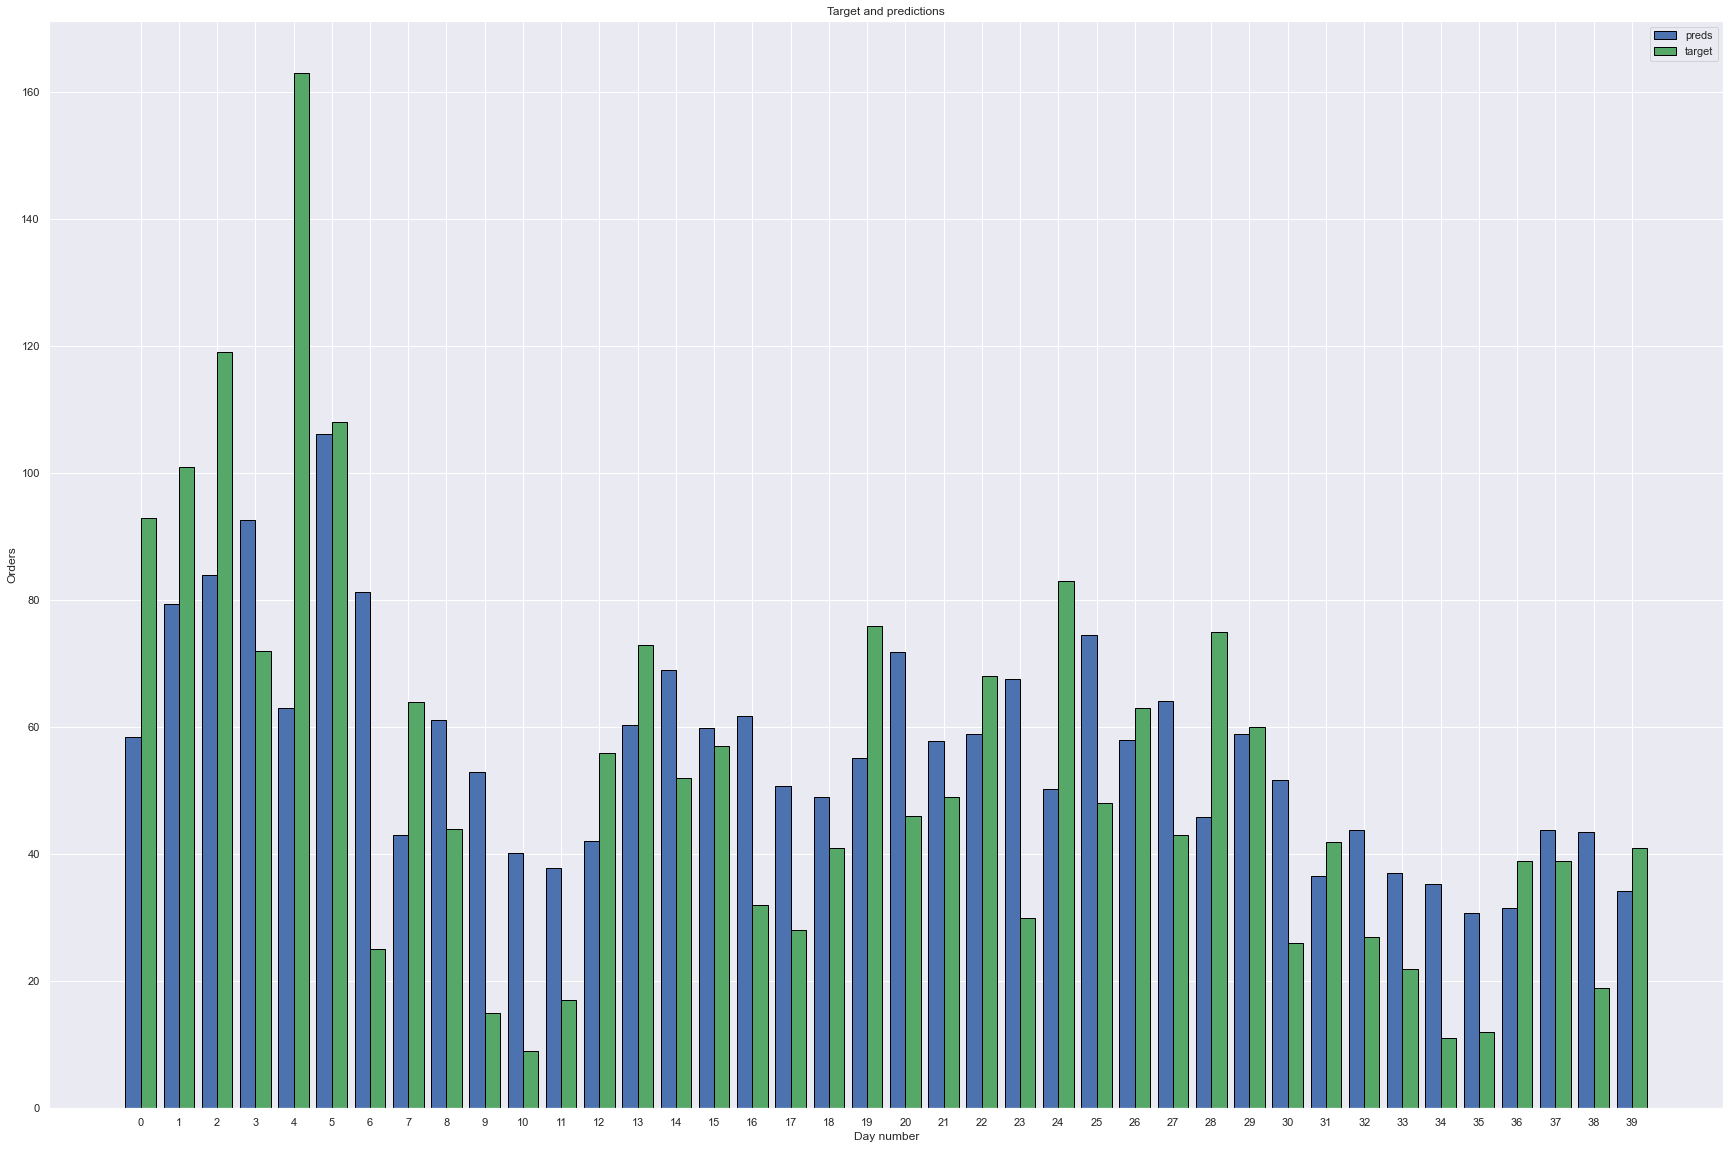

In [52]:
# визуализируем предсказания и таргет
graph_for_fact_and_preds(lr2_predicted_train[start:end], target_train[start:end])

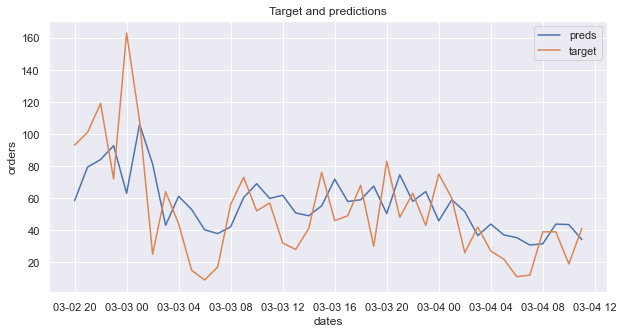

In [53]:
graph_for_fact_and_preds_lines(target_train.index[start:end], lr2_predicted_train[start:end], target_train[start:end])

### Случайный лес
Обучим случайный лес, оценим его результаты.

In [54]:
random_forest_model = RandomForestRegressor(random_state=666)
random_forest_model.fit(features_train, target_train)

random_forest_predicted_train = random_forest_model.predict(features_train)
random_forest_rmse_train = np.sqrt(mean_squared_error(target_train, random_forest_predicted_train))

print("RMSE обучающей выборки:", random_forest_rmse_train)

RMSE обучающей выборки: 8.294053760924493


In [55]:
random_forest_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 666,
 'verbose': 0,
 'warm_start': False}

Подберем параметры на гридсерче.

In [56]:
%%time
estimator = RandomForestRegressor(random_state=666,
                                  verbose=0,
                                  )

params = {#'max_depth': [4, 6, 8, 10, None],
          'min_samples_split': [2, 3, 4, 5, 8, 10],
          'min_samples_leaf': [1, 2, 3, 5, 10],
          #'learning_rate': [0.05, 0.1, 0.2, 0.5],
          'n_estimators': [50, 80, 100, 130, 150, 200]}

grid = GridSearchCV(estimator, 
                   param_grid=params, 
                   scoring='neg_root_mean_squared_error', 
                   refit=True,
                   n_jobs=-1, 
                   cv=tscv, 
                   return_train_score=True,
                   verbose=1)

grid.fit(features_train, target_train) 

Fitting 8 folds for each of 180 candidates, totalling 1440 fits
CPU times: user 4.54 s, sys: 267 ms, total: 4.81 s
Wall time: 6min 14s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=RandomForestRegressor(random_state=666), n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 2, 3, 5, 10],
                         'min_samples_split': [2, 3, 4, 5, 8, 10],
                         'n_estimators': [50, 80, 100, 130, 150, 200]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=1)

In [57]:
print(grid.best_params_)
print(np.sqrt(abs(grid.best_score_)))
print(np.sqrt(mean_squared_error(target_train, grid.predict(features_train))))

{'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 80}
4.814352759904073
14.908087335291135


In [58]:
for x in grid.cv_results_:
    print(x)
    print(grid.cv_results_[x])
    print()

mean_fit_time
[0.48650688 0.71402526 0.94340476 1.14969072 1.37576962 1.79322904
 0.44647151 0.67987195 0.84273592 1.13103586 1.27369294 1.72017816
 0.4028644  0.69234452 0.80225435 1.06223449 1.24710199 1.64622173
 0.39957634 0.62014571 0.77677795 1.03861156 1.16379634 1.57295573
 0.36244363 0.57964468 0.77505744 0.93985    1.11883461 1.45293325
 0.35004508 0.59412956 0.70139781 0.94586241 1.10242388 1.47614554
 0.46656871 0.73847547 0.76686984 1.01430407 1.15965334 2.47178549
 0.50477624 1.02137694 1.20470721 1.42654896 1.53296179 2.1697771
 0.48100427 0.93188366 1.10974652 1.36118871 1.55674788 1.99055782
 0.50768256 0.77716169 1.00302976 1.36275887 1.65760246 2.51671067
 0.46068889 0.79738379 1.17090923 1.57205039 1.16731101 2.16419694
 0.52086556 0.86509043 0.76872665 1.12078595 1.2902889  1.54578024
 0.39267257 0.57147518 0.76538566 0.95965853 1.10976407 1.45947909
 0.36586383 0.64180645 0.72423744 0.96184716 1.12918028 1.72342813
 0.39563033 0.8059788  0.84879804 1.06361014 1.22

In [59]:
random_forest_model_2 = RandomForestRegressor(n_estimators=200,
                                              min_samples_split=2,
                                              min_samples_leaf=10)
random_forest_model_2.fit(features_train, target_train)

random_forest2_predicted_train = random_forest_model_2.predict(features_train)
random_forest2_rmse_train = np.sqrt(mean_squared_error(target_train, random_forest2_predicted_train))

print("RMSE обучающей выборки:", random_forest2_rmse_train)

RMSE обучающей выборки: 18.68665420027287


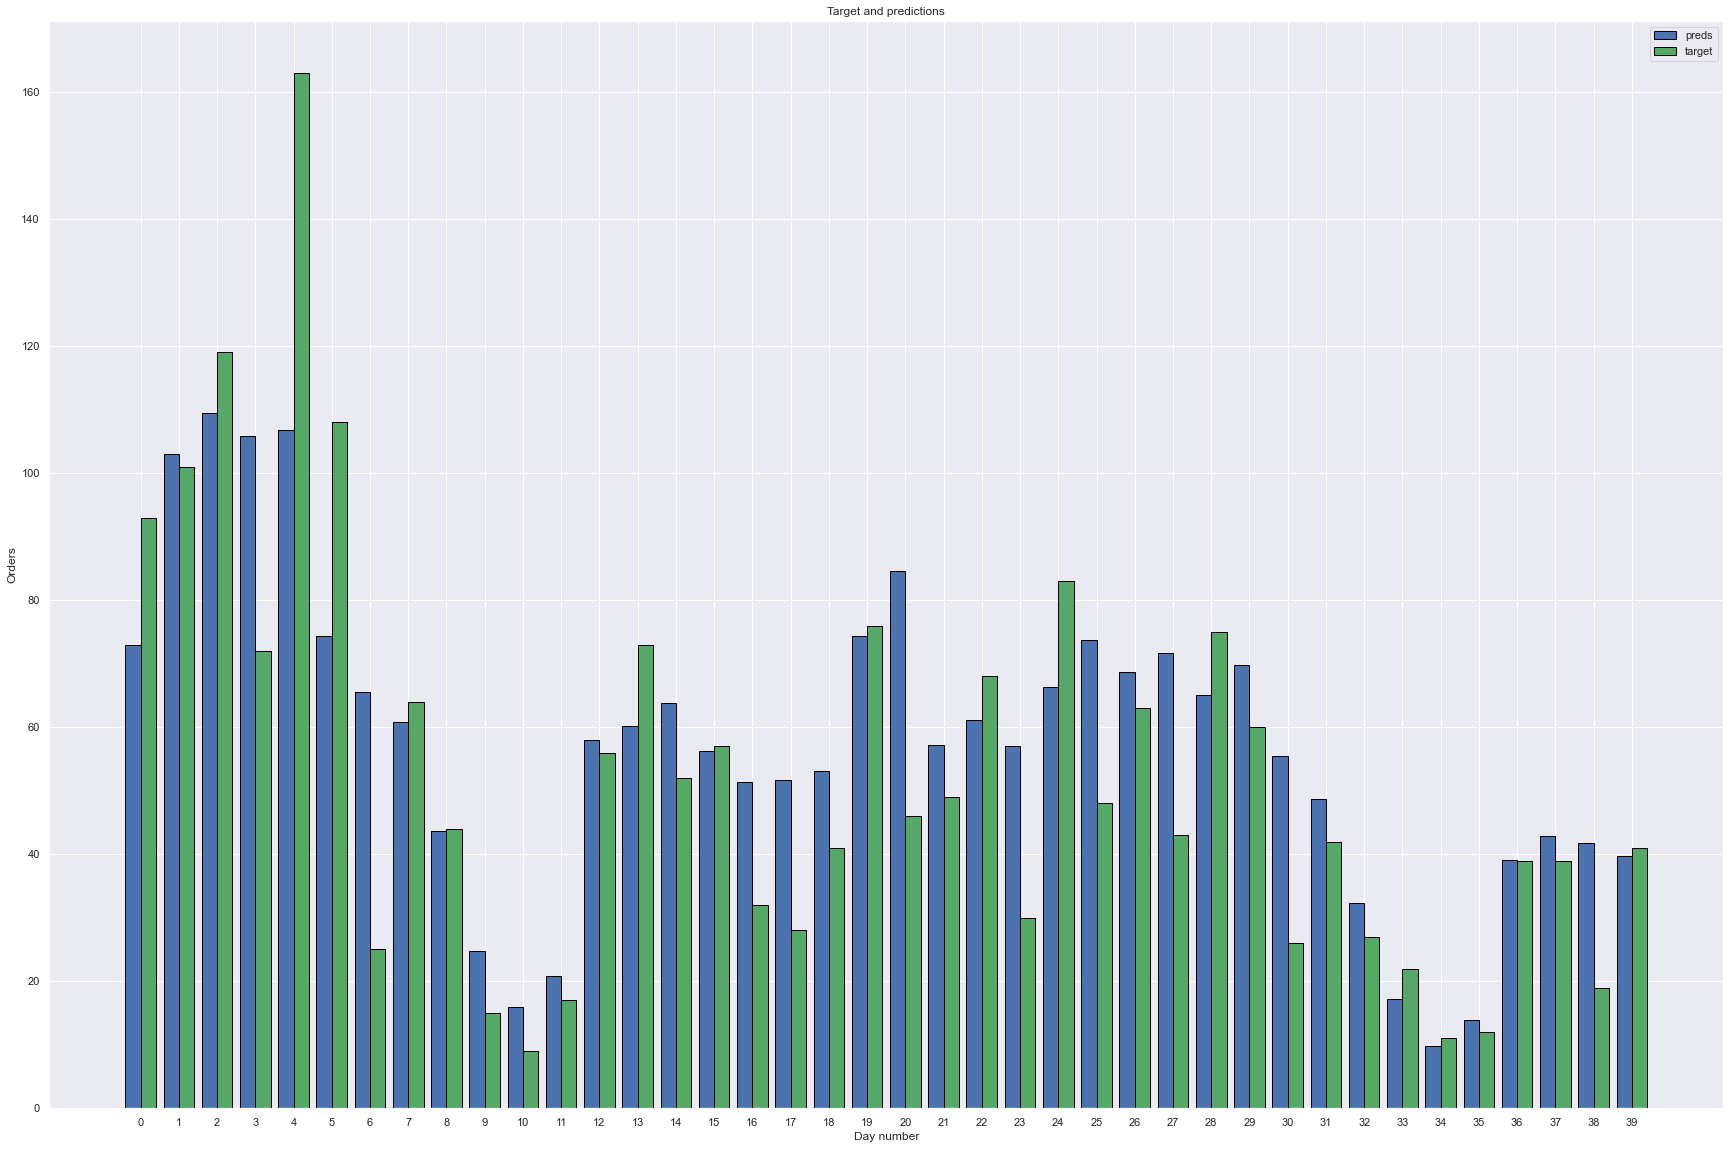

In [60]:
# визуализируем предсказания и таргет
graph_for_fact_and_preds(random_forest2_predicted_train[start:end], target_train[start:end])

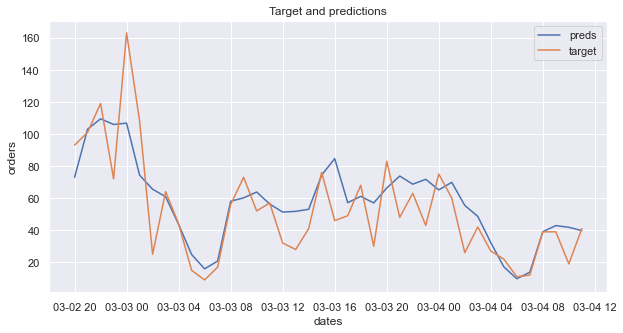

In [61]:
graph_for_fact_and_preds_lines(target_train.index[start:end], random_forest2_predicted_train[start:end], target_train[start:end])

Результат получился лучше, чем у линейной регрессии.

### CatBoostRegressor
Попробуем предсказать результаты с помощью CatBoostRegressor.

In [62]:
%%time
catboost_model = CatBoostRegressor(verbose=0, random_seed=666)
catboost_model.fit(features_train, target_train)

catboost_predicted_train = catboost_model.predict(features_train)
catboost_rmse_train = np.sqrt(mean_squared_error(target_train, catboost_predicted_train))
print("RMSE обучающей выборки:", catboost_rmse_train)

RMSE обучающей выборки: 14.550734323009383
CPU times: user 3.78 s, sys: 966 ms, total: 4.75 s
Wall time: 1.43 s


In [63]:
print(catboost_model.get_all_params()['iterations'])
print(catboost_model.get_all_params()['depth'])
print(catboost_model.get_all_params()['max_leaves'])
print(catboost_model.get_all_params()['learning_rate'])

1000
6
64
0.04975299909710884


Подберем оптимальные параметры на GridSearchCV.

In [64]:
%%time
estimator = CatBoostRegressor(random_state=666,
                              verbose=0,
                              )

params = {'iterations': [100, 200, 500, 1_000, 2_000],
          'depth': [4, 6, 8, 10, None],
          'learning_rate': [0.05, 0.1, 0.5]}

grid = GridSearchCV(estimator, 
                   param_grid=params, 
                   scoring='neg_root_mean_squared_error', 
                   refit=True,
                   n_jobs=-1, 
                   cv=tscv, 
                   return_train_score=True,
                   verbose=0)

grid.fit(features_train, target_train) 

CPU times: user 2.04 s, sys: 255 ms, total: 2.3 s
Wall time: 19min 17s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f51bf618880>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8, 10, None],
                         'iterations': [100, 200, 500, 1000, 2000],
                         'learning_rate': [0.05, 0.1, 0.5]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [65]:
print(grid.best_params_)
print(np.sqrt(abs(grid.best_score_))) # on train or test?
print(np.sqrt(mean_squared_error(target_train, grid.predict(features_train))))

{'depth': 6, 'iterations': 100, 'learning_rate': 0.1}
4.843603442074487
19.6218224726697


In [66]:
catboost_model_2 = CatBoostRegressor(verbose=0, 
                                     random_seed=666, 
                                     learning_rate=0.05,
                                     iterations=100,
                                     depth=4)
catboost_model_2.fit(features_train, target_train)

catboost2_predicted_train = catboost_model_2.predict(features_train)
catboost2_rmse_train = np.sqrt(mean_squared_error(target_train, catboost2_predicted_train))
print("RMSE обучающей выборки:", catboost2_rmse_train)

RMSE обучающей выборки: 22.58501274950122


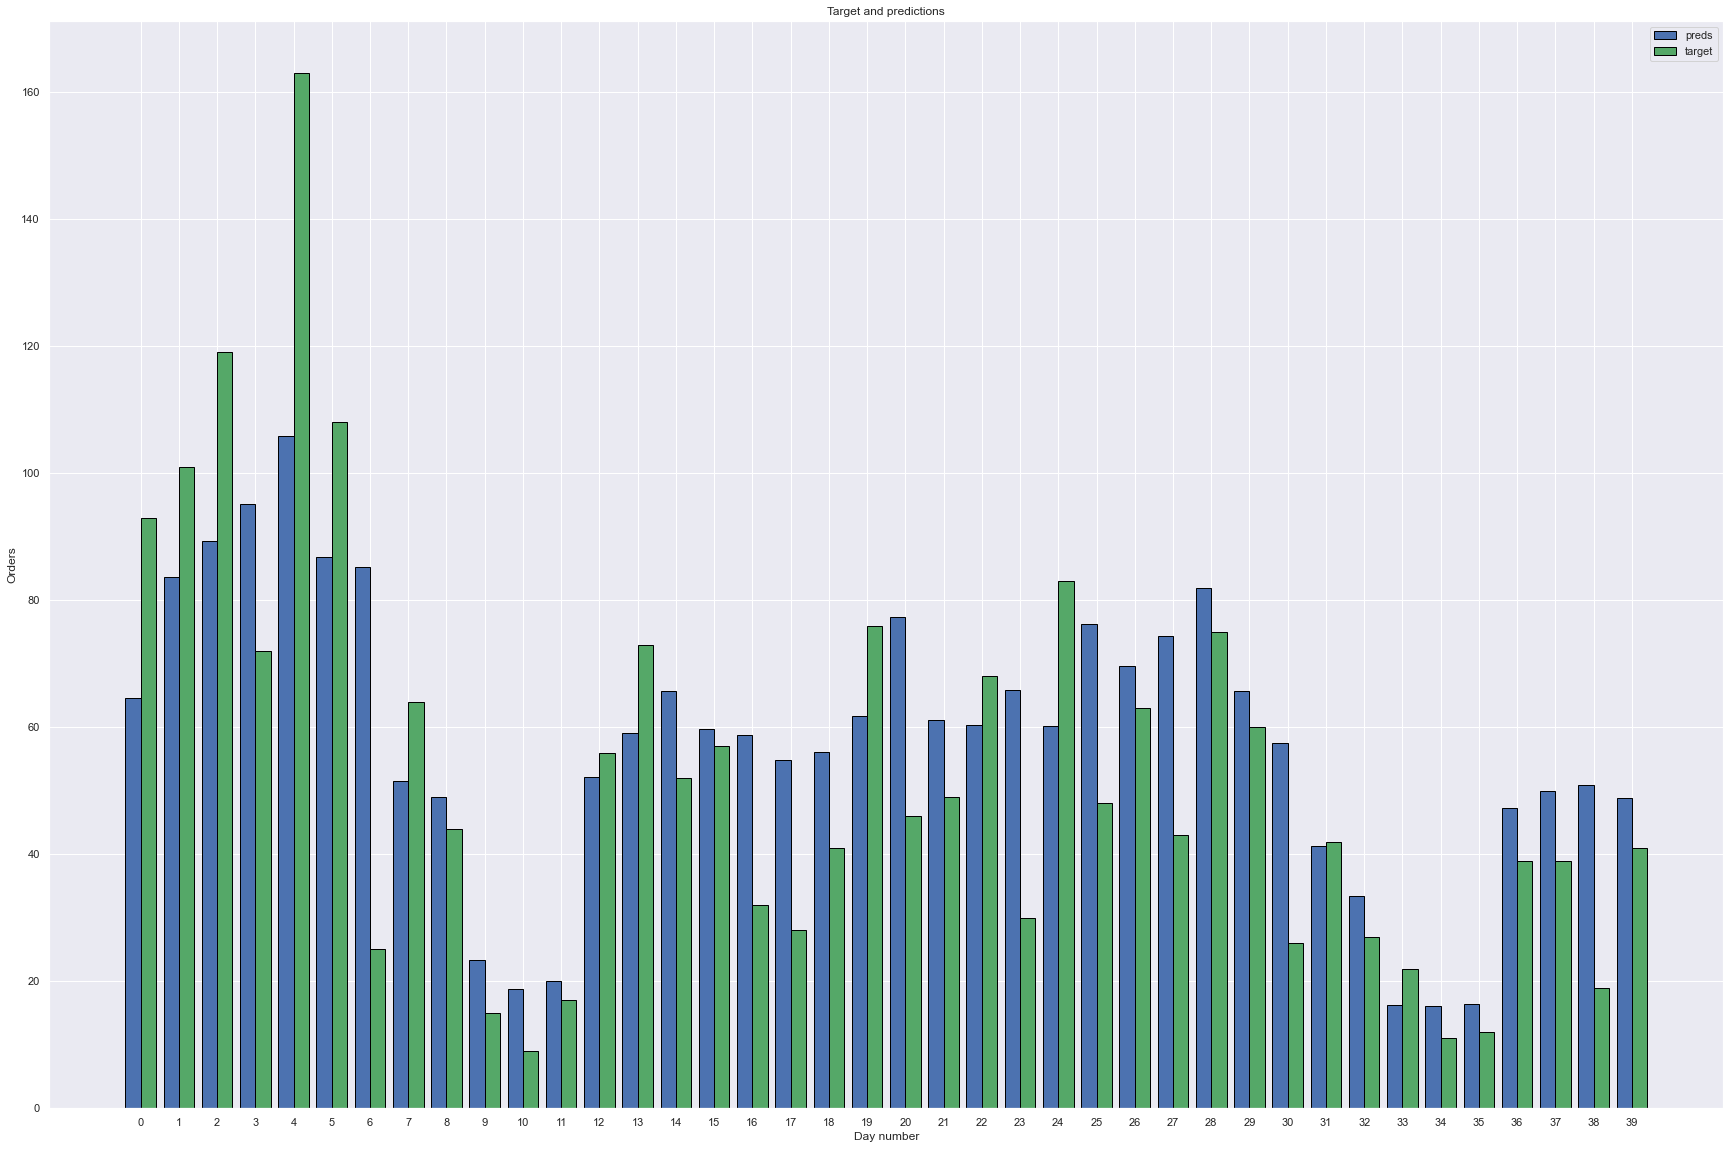

In [67]:
# визуализируем предсказания и таргет
graph_for_fact_and_preds(catboost2_predicted_train[start:end], target_train[start:end])

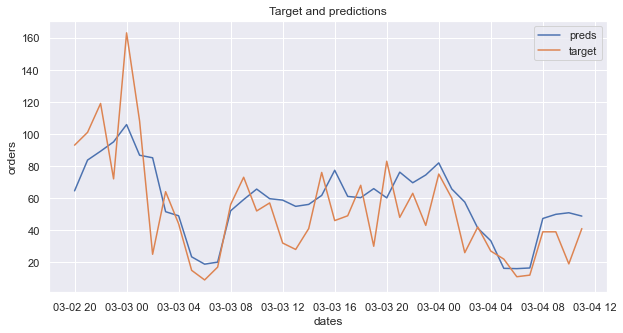

In [68]:
graph_for_fact_and_preds_lines(target_train.index[start:end], catboost2_predicted_train[start:end], target_train[start:end])

### LightGBM модели
Обучим LightGBM модели и оценим их эффективность.

In [69]:
%%time
lgb_model = lgb.LGBMRegressor(random_state=666)
lgb_model.fit(features_train, target_train)

lgb_predicted_train = lgb_model.predict(features_train)
lgb_rmse_train = np.sqrt(mean_squared_error(target_train, lgb_predicted_train))
print("RMSE обучающей выборки:", lgb_rmse_train)

RMSE обучающей выборки: 15.674291269516575
CPU times: user 470 ms, sys: 21.5 ms, total: 492 ms
Wall time: 174 ms


In [70]:
lgb_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 666,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [83]:
%%time 
estimator = lgb.LGBMRegressor(random_state=666,
                               verbose=-1
                               )
                              
params = {#'l2_leaf_reg': [3, 5, 9],
          'n_estimators': [10, 20, 50, 80, 100, 200],
          'min_data_in_leaf': [30, 50, 100, 200],
          'max_depth': [-1, 2, 4, 6, 10, 15, 20],
          'num_iterations': [50, 100, 200, 500, 1000],
          'learning_rate': [0.05, 0.1, 0.2, 0.5]
          }
                              
grid =   RandomizedSearchCV(estimator, 
                      params,
                      scoring='neg_root_mean_squared_error',
                      refit=True,
                      cv=2, 
                      verbose=-1, 
                      n_jobs=-1,
                     ) 

grid.fit(features_train, target_train) 

CPU times: user 321 ms, sys: 59.2 ms, total: 380 ms
Wall time: 2.65 s


RandomizedSearchCV(cv=2, estimator=LGBMRegressor(random_state=666, verbose=-1),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2, 0.5],
                                        'max_depth': [-1, 2, 4, 6, 10, 15, 20],
                                        'min_data_in_leaf': [30, 50, 100, 200],
                                        'n_estimators': [10, 20, 50, 80, 100,
                                                         200],
                                        'num_iterations': [50, 100, 200, 500,
                                                           1000]},
                   scoring='neg_root_mean_squared_error', verbose=-1)

In [84]:
print(grid.best_params_)
print(np.sqrt(abs(grid.best_score_))) 

{'num_iterations': 100, 'n_estimators': 10, 'min_data_in_leaf': 30, 'max_depth': 10, 'learning_rate': 0.05}
5.196792044968412


In [85]:
lgb_model_2 = lgb.LGBMRegressor(verbose=-1, 
                            random_seed=666, 
                            learning_rate=0.05,
                            num_iterations=100,
                            n_estimators=10,
                            min_data_in_leaf=30,
                            max_depth=10)
lgb_model_2.fit(features_train, target_train)

lgb2_predicted_train = lgb_model_2.predict(features_train)
lgb2_rmse_train = np.sqrt(mean_squared_error(target_train, lgb2_predicted_train))
print("RMSE обучающей выборки:", lgb2_rmse_train)

RMSE обучающей выборки: 18.285284095273756


Результат чуть хуже, чем у модели без параметров.

Попробуем другие параметры на гриде.

In [86]:
%%time 
estimator = lgb.LGBMRegressor(random_state=666,
                               verbose=-1
                               )
                              
params = {'n_estimators': [10, 15, 20, 50],
          'min_data_in_leaf': [30, 50, 100, 200],
          'max_depth': [-1, 2, 10],
          'min_child_samples': [5, 10, 20, 50],
          'num_leaves': [20, 50, 100, 200, 500, 1000],
          'learning_rate': [0.05, 0.1, 0.2, 0.5]
          }
                              
grid =   GridSearchCV(estimator, 
                      params,
                      scoring='neg_root_mean_squared_error',
                      refit=True,
                      cv=2, 
                      verbose=-1, 
                      n_jobs=-1,
                     ) 

grid.fit(features_train, target_train) 

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_d

GridSearchCV(cv=2, estimator=LGBMRegressor(random_state=666, verbose=-1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2, 0.5],
                         'max_depth': [-1, 2, 10],
                         'min_child_samples': [5, 10, 20, 50],
                         'min_data_in_leaf': [30, 50, 100, 200],
                         'n_estimators': [10, 15, 20, 50],
                         'num_leaves': [20, 50, 100, 200, 500, 1000]},
             scoring='neg_root_mean_squared_error', verbose=-1)

In [87]:
print(grid.best_params_)
print(np.sqrt(abs(grid.best_score_)))

{'learning_rate': 0.2, 'max_depth': 10, 'min_child_samples': 5, 'min_data_in_leaf': 30, 'n_estimators': 50, 'num_leaves': 20}
5.183522492214276


In [88]:
lgb_model_3 = lgb.LGBMRegressor(verbose=-1, 
                                random_seed=666, 
                                num_leaves=20,
                                learning_rate=0.2,
                                n_estimators=50,
                                min_data_in_leaf=30,
                                min_child_samples=5,
                                max_depth=10)
lgb_model_3.fit(features_train, target_train)

lgb3_predicted_train = lgb_model_3.predict(features_train)
lgb3_rmse_train = np.sqrt(mean_squared_error(target_train, lgb3_predicted_train))
print("RMSE обучающей выборки:", lgb3_rmse_train)

RMSE обучающей выборки: 17.47448616621603


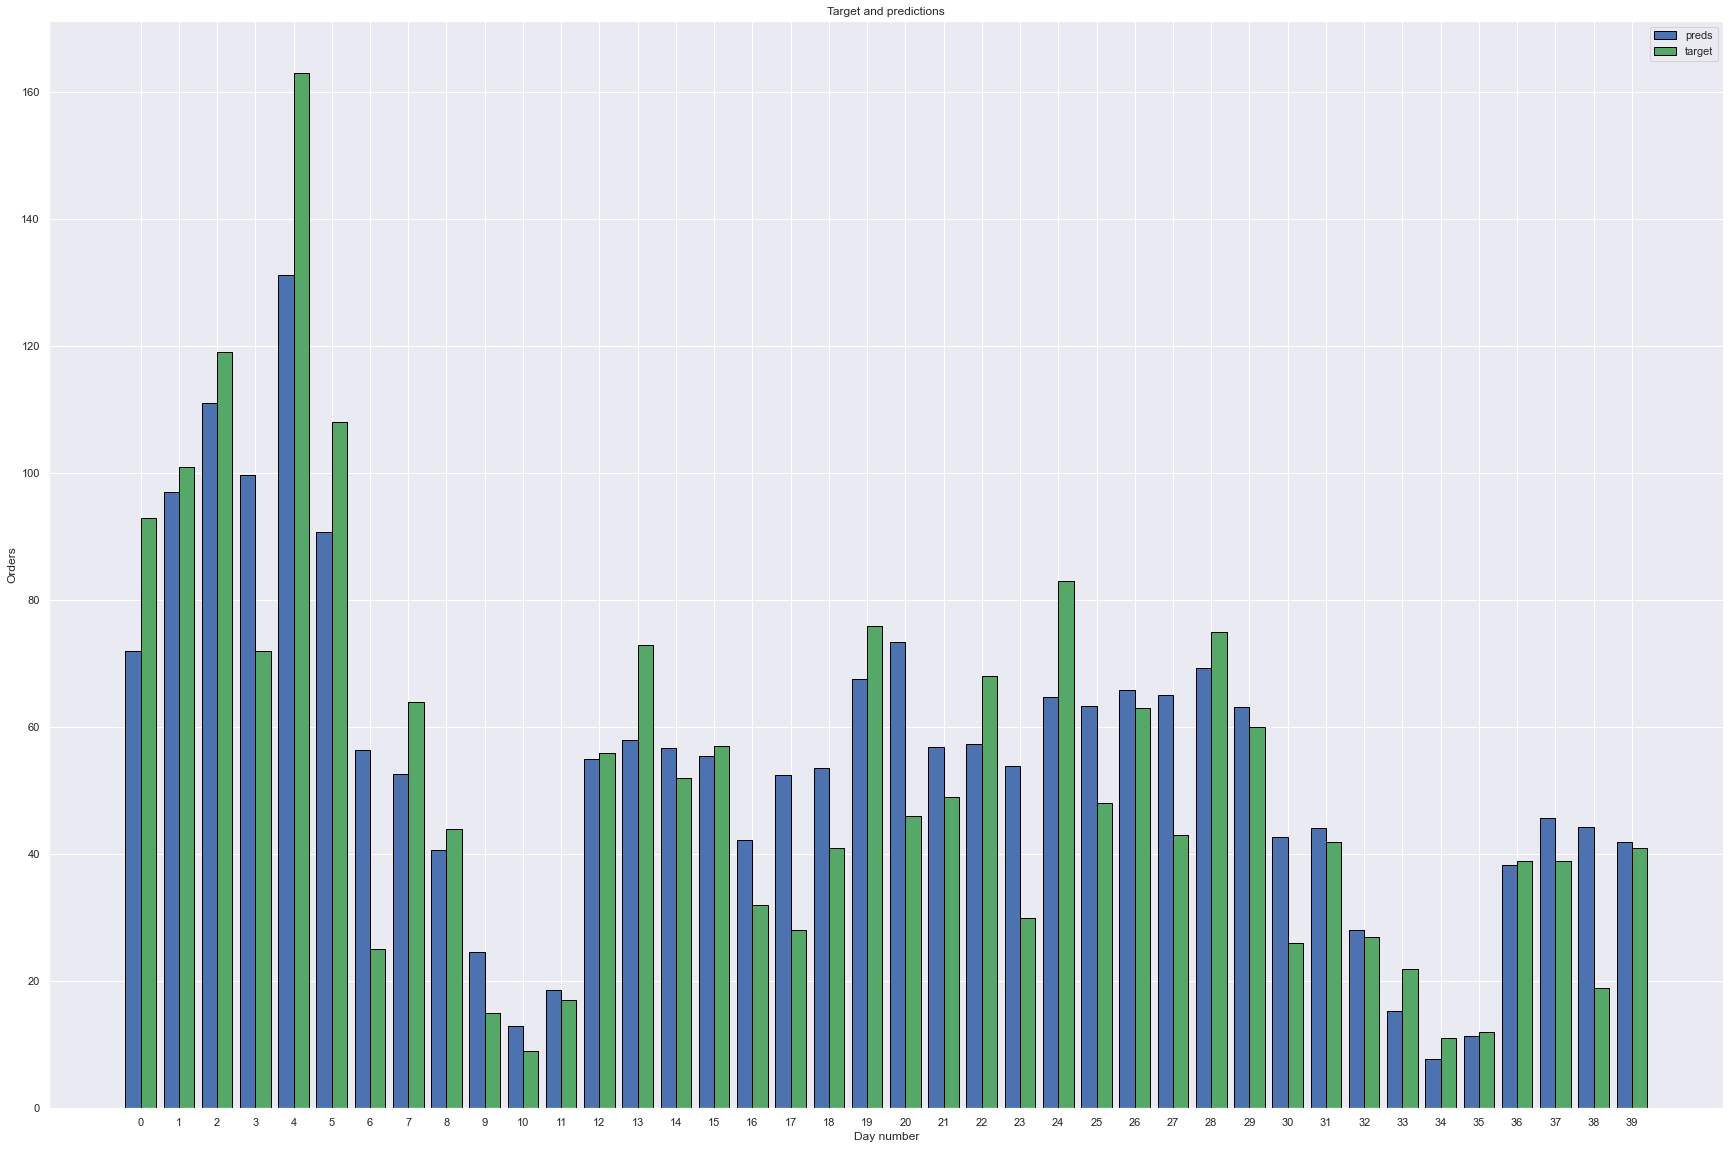

In [89]:
# визуализируем предсказания и таргет для лучшей модели
graph_for_fact_and_preds(lgb_predicted_train[start:end], target_train[start:end])

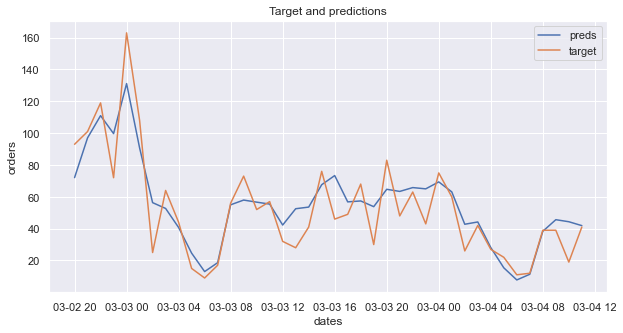

In [90]:
graph_for_fact_and_preds_lines(target_train.index[start:end], lgb_predicted_train[start:end], target_train[start:end])

## Сравнение моделей и выбор лучшей модели
### Сравнение моделей
Сравнительные результаты работы моделей приведены в таблице. 

In [91]:
data = {'models': ['lr_model',
                   'lr_model_2',
                   'random_forest_model',
                   'random_forest_model_2',
                   'catboost_model', 
                   'catboost_model_2', 
                   'lgb_model',
                   'lgb_model_2',
                   'lgb_model_3'], 
        'rmse_train': [lr_rmse_train,
                       lr2_rmse_train,
                       random_forest_rmse_train,
                       random_forest2_rmse_train,
                       catboost_rmse_train,
                       catboost2_rmse_train,
                       lgb_rmse_train,
                       lgb2_rmse_train,
                       lgb3_rmse_train],
#         'rmse_test':  [lr_rmse_test,
#                        lr2_rmse_test,
#                        random_forest_rmse_test,
#                        random_forest2_rmse_test,
#                        catboost_rmse_test,
#                        catboost2_rmse_test,
#                        lgb_rmse_test,
#                        lgb2_rmse_test,
#                        lgb3_rmse_test],
       }
results = pd.DataFrame(data=data)
results

,models,rmse_train
0,lr_model,29.2902
1,lr_model_2,29.2977
2,random_forest_model,8.2941
3,random_forest_model_2,18.6867
4,catboost_model,14.5507
5,catboost_model_2,22.5850
6,lgb_model,15.6743
7,lgb_model_2,18.2853
8,lgb_model_3,17.4745


Лучше всего результат на трейне у модели random_forest_model, обученной с параметрами по умолчанию. Определим ее как лучшую модель.

In [92]:
best_model = random_forest_model
print(best_model)

RandomForestRegressor(random_state=666)


Сделаем предсказания модели на тесте и оценим RMSE:

In [94]:
predicted_test = best_model.predict(features_test)
rmse_test = np.sqrt(mean_squared_error(target_test, predicted_test))
print('RMSE на тесте:', rmse_test)

RMSE на тесте: 38.30535721217729


RMSE на трейне значительно ниже, чем RMSE на тесте.

Визуализируем предсказания лучшей модели на тесте. 

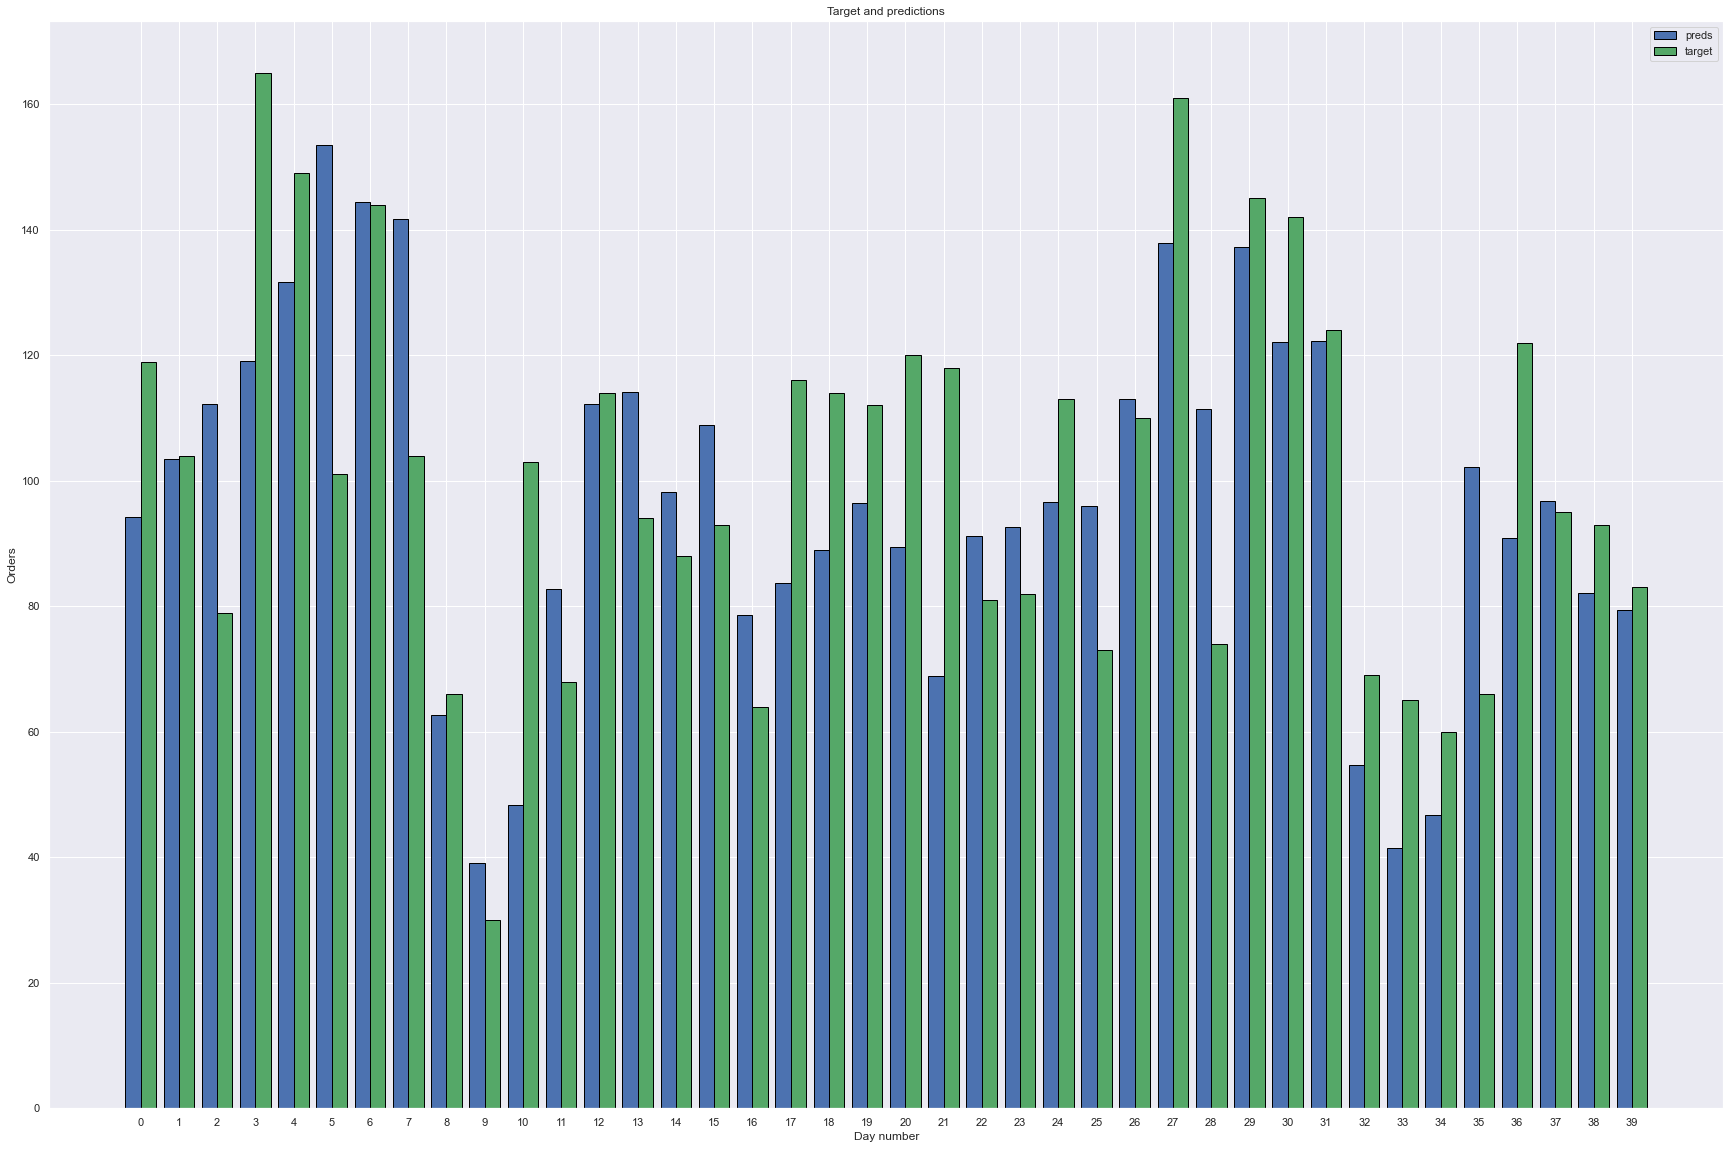

In [95]:
start, end = 20, 60
graph_for_fact_and_preds(predicted_test[start:end], target_test[start:end])

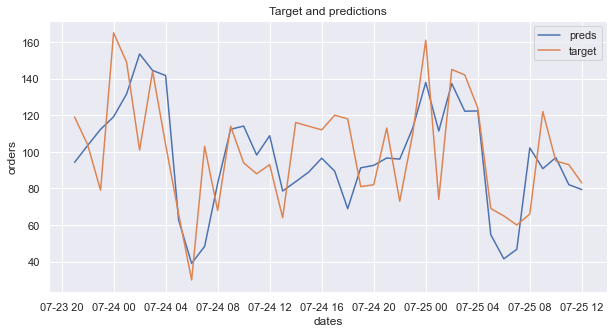

In [96]:
graph_for_fact_and_preds_lines(target_test.index[start:end], predicted_test[start:end], target_test[start:end])

Рассчитаем систематическую ошибку bias.

In [97]:
def bias(y_pred, y_true): 
    return sum(y_pred - y_true) / sum(y_true)

In [98]:
print(bias(random_forest_predicted_train, target_train))
print(bias(predicted_test, target_test))

0.002194941769511559
-0.1606548799937761


Модель в основном занижает значения, на трейне меньше, чем на тесте. 

## Вывод
### Постановка задачи
Заказчик исследования - агрегатор такси "Четенькое такси". Задача - предсказать количество заказов на следующий час для решения бизнес-задач. 

### Импорт и первичное исследование данных
Исходные данные - датасет на 26_496 строк и одну колонку. Колонку с датами импортировали как индекс. Вторая колонка - количество заказов в формате int64. Пропусков нет.

Датасет включает в себя данные за полгода - с 1 марта по 31 августа 2018, то есть сезонные колебания (зима, весна, лето, осень) в датасете не отражены.

Данные имеют шаг 10 минут.

Была проведена декомпозиция данных на тренд, сезонность и остатки. Тренд на протяжении месяцев растущий, что делает временной ряд не стационарным (среднее растет). Сезонность проявляется в течение суток. Остатки довольно значительные, что негативно влияет на качество предсказаний моделей. 

### Предобработка данных
Лишних столбцов нет, дубликатов не может быть, т.к. индекс - уникальная дата+время. Единственный столбец поименован нормально, тип данных соответствует физическому смыслу столбца (менять типы данных не надо), пропусков нет.

В задании указано, что предсказывать нужно нагрузку на следующий час. Данные были ресемплированы, интервал заменен на один час.

Существенных выбросов в датасете нет. На позднейшей по времени части датасета, которая попадет в тестовую часть, есть выбросы - значения num_orders > 300. В трех случаях эти выбросы приходятся на 02:00 понедельника, в одном случае - на четверг. Значения заменены для понедельников - на медиану по предыдущим понедельникам за месяц, для четверга - на медиану четвергов.

Были созданы дополнительные обучающие признаки, описывающие количество заказов в предыдущие 2 часа. Для первых двух часов часть новых признаков пустая, поэтому эти строки были удалены. В обучающие признаки добавлены также день недели, день месяца и час дня.

### Подготовка датасетов
Исходный датасет был разделен на тренировочный и тестовый в соотношении 4:1. 

### Обучение моделей
На датасете обучены модели:
* LinearRegressor
* RandomForestRegressor
* CatBoostRegressor
* LGBMRegressor

Модели сначала обучены с дефолтными параметрами, затем гиперпараметры подобраны на GridSearchCV. 

Ключевые метрики моделей приведены в таблице:


In [99]:
results

,models,rmse_train
0,lr_model,29.2902
1,lr_model_2,29.2977
2,random_forest_model,8.2941
3,random_forest_model_2,18.6867
4,catboost_model,14.5507
5,catboost_model_2,22.5850
6,lgb_model,15.6743
7,lgb_model_2,18.2853
8,lgb_model_3,17.4745


### Вывод
Лучше всего показала себя модель случайного леса, обученная с дефолтными параметрами. 

In [100]:
best_model

RandomForestRegressor(random_state=666)

In [101]:
best_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 666,
 'verbose': 0,
 'warm_start': False}

Метрика на тесте rmse_test = 38.3, что меньше стандартного отклонения датасета std = 44.40. 

In [102]:
print('RMSE на тесте:', rmse_test)

RMSE на тесте: 38.30535721217729


Визуализация части предсказаний на тестовом датасете выглядит так:

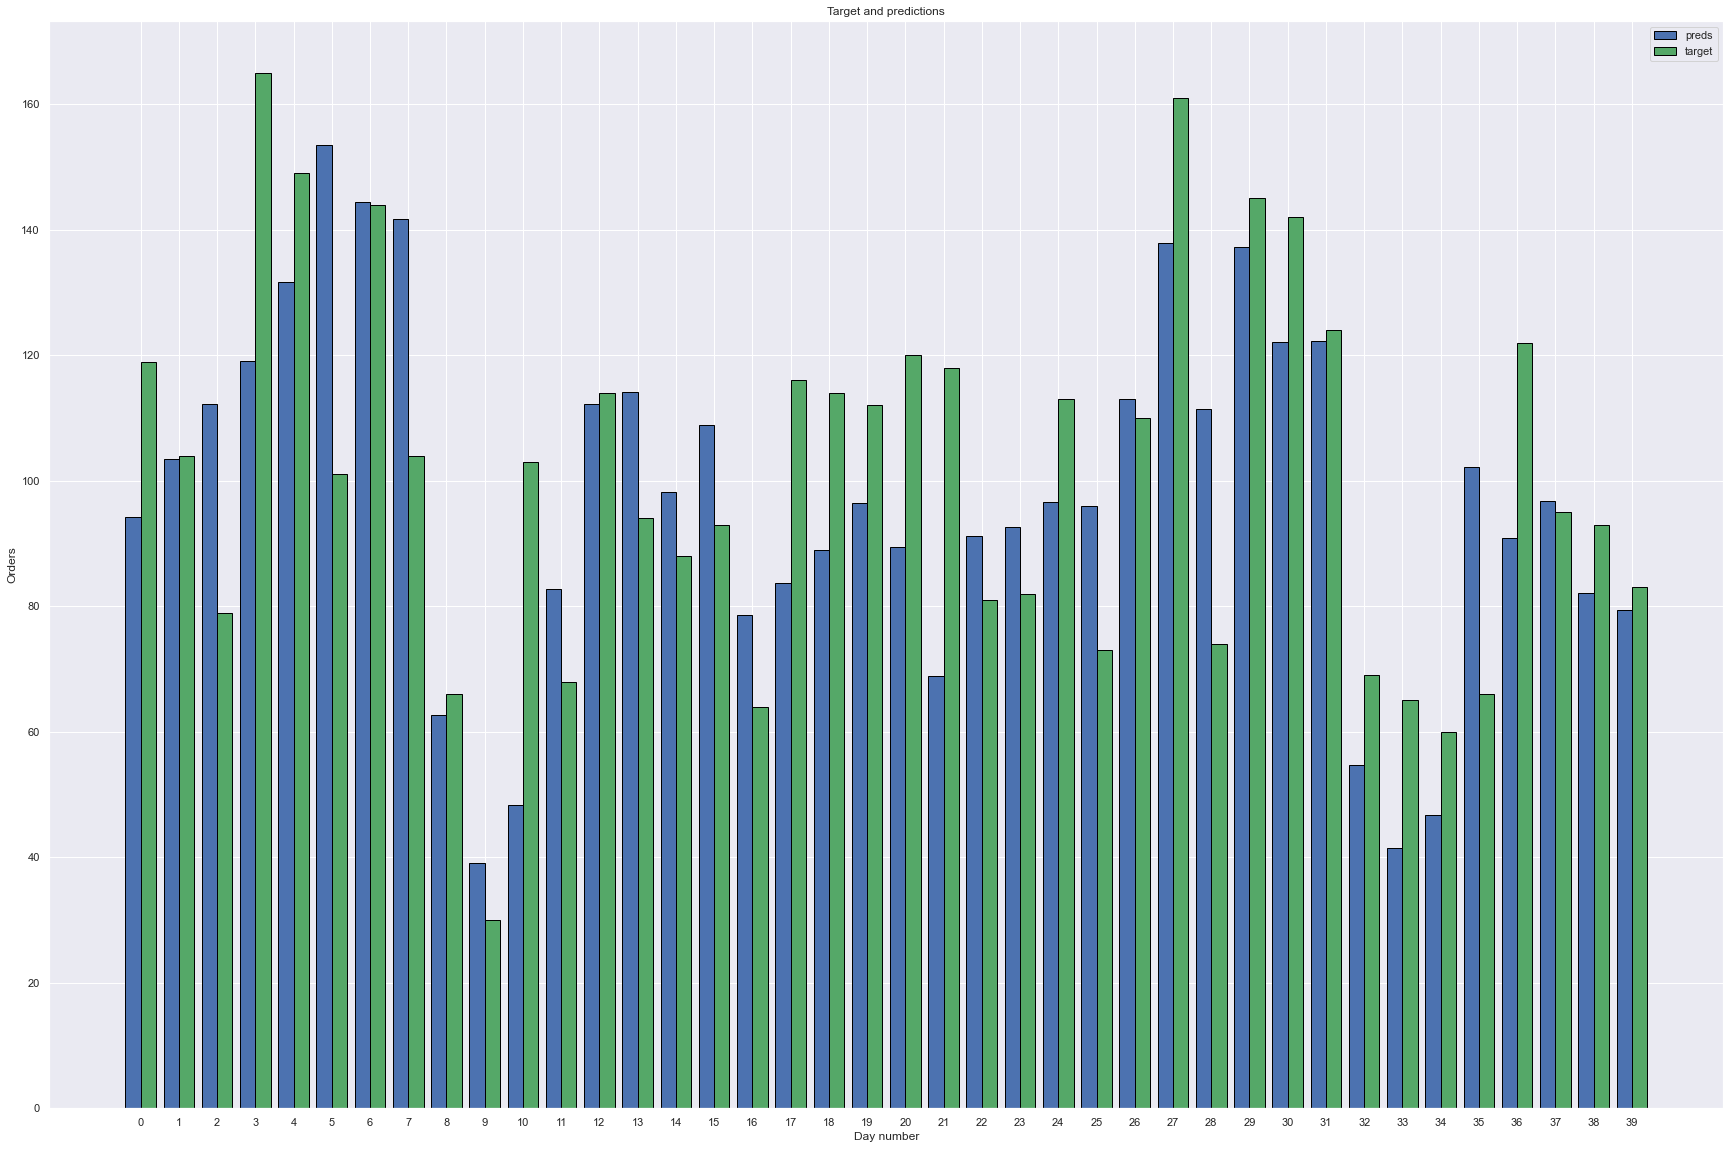

In [104]:
graph_for_fact_and_preds(predicted_test[start:end], target_test[start:end])

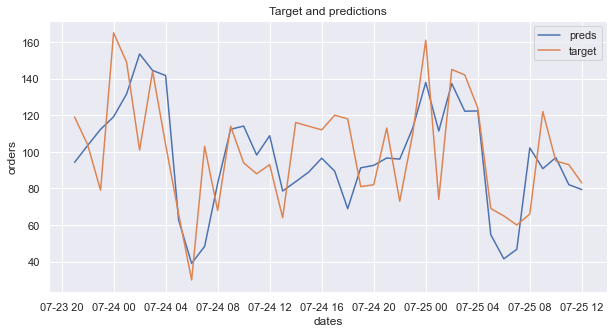

In [105]:
graph_for_fact_and_preds_lines(target_test.index[start:end], predicted_test[start:end], target_test[start:end])

Модель в основном занижает значения, на трейне меньше, чем на тесте.  Кроме того, судя по графикам, модели улавливают закономерности, но с определенным запозданием, и сглаживают экстремальные значения.

Модель рекомендуется к дообучению.